## Import the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet150 import ResNet150

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

path_drive='/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T03'

Mounted at /content/gdrive/


## Database: BloodMNIST




### Connect with database

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cach

In [ ]:
from medmnist import BloodMNIST, INFO, Evaluator

### Collect specific dataset to train, test and validation

In [ ]:
# distinct labels classifications
dict_classes= {
  '0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'
 }

In [ ]:
size_dimension= 28

data_train= BloodMNIST(split="train", download=True, size=size_dimension)
data_val=   BloodMNIST(split="val", download=True, size=size_dimension)
data_test=  BloodMNIST(split="test", download=True, size=size_dimension)

100%|██████████| 35461855/35461855 [00:02<00:00, 16394517.43it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [ ]:
## split the datasets
X_train, y_train= data_train.imgs, data_train.labels
X_val, y_val= data_val.imgs, data_val.labels
X_test, y_test= data_test.imgs, data_test.labels

In [ ]:
X_train[0]

array([[[250, 223, 206],
        [255, 229, 212],
        [251, 222, 206],
        ...,
        [255, 238, 195],
        [251, 230, 185],
        [255, 234, 191]],

       [[255, 229, 210],
        [255, 229, 210],
        [244, 215, 199],
        ...,
        [254, 232, 193],
        [254, 233, 190],
        [255, 242, 201]],

       [[255, 231, 208],
        [255, 227, 205],
        [238, 210, 189],
        ...,
        [255, 233, 202],
        [251, 229, 192],
        [255, 242, 203]],

       ...,

       [[233, 204, 172],
        [239, 210, 180],
        [245, 218, 188],
        ...,
        [255, 225, 199],
        [255, 226, 200],
        [255, 228, 199]],

       [[215, 184, 156],
        [218, 188, 160],
        [228, 198, 170],
        ...,
        [255, 225, 201],
        [254, 227, 200],
        [255, 228, 201]],

       [[217, 182, 162],
        [212, 180, 159],
        [213, 181, 158],
        ...,
        [254, 226, 204],
        [255, 227, 203],
        [255, 228, 201]]], dtype=uint8)

In [ ]:
# it's always better to normalize
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [ ]:
# Reshape to be [samples][width][height][channels]
size_dimension_updated= 32          ## resnet apply this dimension

# resize the input shape , i.e. old shape: 28, new shape: 32
X_train = tf.image.resize(X_train, [size_dimension_updated, size_dimension_updated]) # if we want to resize
X_val = tf.image.resize(X_val, [size_dimension_updated, size_dimension_updated])
X_test = tf.image.resize(X_test, [size_dimension_updated, size_dimension_updated])

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train , num_classes=8)
y_val = tf.keras.utils.to_categorical(y_val , num_classes=8)
y_test = tf.keras.utils.to_categorical(y_test , num_classes=8)

# y_train = y_train.flatten()
# y_val = y_val.flatten()
# y_test = y_test.flatten()

### Visualizing the actual data

In [ ]:
# y_train.replace(dict_classes)
print(y_train.ravel())
a= [dict_classes[str(i)] for i in y_train.ravel()]
print(a)

[7 3 6 ... 1 6 4]
['platelet', 'immature granulocytes', 'neutrophil', 'neutrophil', 'platelet', 'neutrophil', 'erythroblast', 'erythroblast', 'platelet', 'erythroblast', 'eosinophil', 'eosinophil', 'neutrophil', 'platelet', 'neutrophil', 'immature granulocytes', 'platelet', 'erythroblast', 'neutrophil', 'eosinophil', 'neutrophil', 'eosinophil', 'monocyte', 'monocyte', 'platelet', 'platelet', 'basophil', 'neutrophil', 'lymphocyte', 'monocyte', 'immature granulocytes', 'erythroblast', 'eosinophil', 'eosinophil', 'neutrophil', 'neutrophil', 'eosinophil', 'lymphocyte', 'basophil', 'lymphocyte', 'neutrophil', 'immature granulocytes', 'basophil', 'eosinophil', 'eosinophil', 'monocyte', 'immature granulocytes', 'basophil', 'immature granulocytes', 'monocyte', 'eosinophil', 'platelet', 'lymphocyte', 'lymphocyte', 'eosinophil', 'platelet', 'neutrophil', 'neutrophil', 'erythroblast', 'eosinophil', 'neutrophil', 'lymphocyte', 'lymphocyte', 'immature granulocytes', 'monocyte', 'eosinophil', 'immat

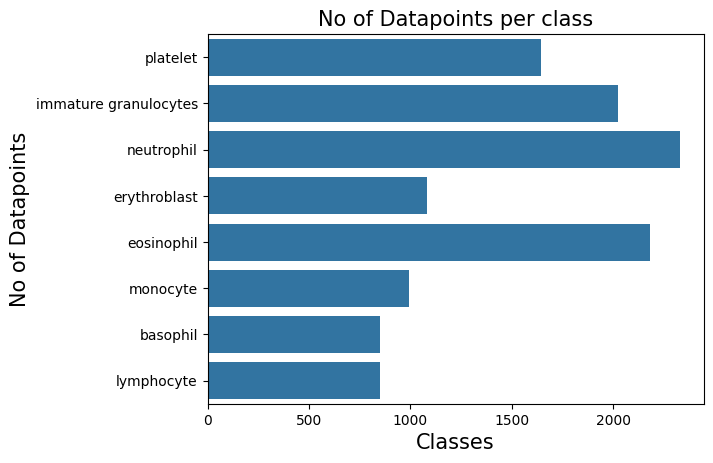

In [ ]:
plt.title('No of Datapoints per class', fontsize=15)
sns.countplot(a)
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of Datapoints', fontsize=15)
plt.xticks()
plt.savefig(f'{path_drive}/NDatapointsPerClass.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/NDatapointsPerClass.png', format='png', bbox_inches="tight")
plt.show()

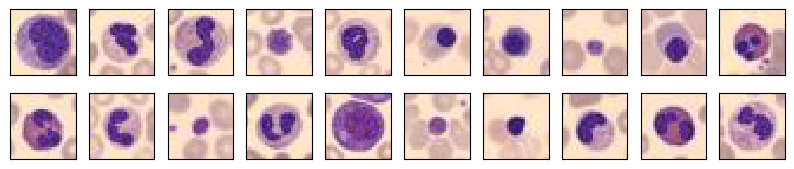

In [ ]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(10, 2))
# plt.title('Original Train Images', fontsize=15)
ind = 1
for i in range(1, 3, 1):
    for j in range(1, 11, 1):
        fig.add_subplot(2, 10, ind)
        plt.imshow(X_train[ind], interpolation = "none")
        plt.xticks([])
        plt.yticks([])
        ind+=1
# plt.set_axis_off()
plt.savefig(f'{path_drive}/fig_train_images.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/fig_train_images.png', format='png', bbox_inches="tight")
plt.show()

## Functions and definitions

### Creation of Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_conf_matrix(y_test=[], pred_lr=[], title="Logistic Regression (newton-cg)", show_plot=True, cm=[],  details="", path_compl="" ):
  # Get the confusion matrix
  if len(cm) == 0:
    cm = confusion_matrix(y_test.flatten(), pred_mlp2.flatten())

  class_names = ['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

  # Create a heatmap of the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

  # Add labels and title
  plt.xlabel("Predicted", fontsize=14)
  plt.ylabel("Actual", fontsize=14)
  plt.title(f'Confusion Matrix for {title}', fontsize=16)

  # Save the plot
  plt.savefig(f'{path_drive}/ResNet/{path_compl}_fig_cm_{details}.eps', format='eps', bbox_inches="tight")
  plt.savefig(f'{path_drive}/ResNet/{path_compl}_fig_cm_{details}.png', format='png', bbox_inches="tight")

  # Show the plot
  if show_plot:
    plt.show()

### Training Resnet

Camadas aplicadas:
- Resnet50
- Flatten()
- Dense(1024)
- Dense(8)

In [ ]:
from tensorflow.keras import datasets, layers, models, losses, Model

def setup_RESNET_model(units=1024, drop_out=0, batch_size=64, epochs=5, n=1,
                    algorithm='sparse_categorical_crossentropy',
                    qtd_kernel=15, height_k=3, width_k=3, activation='relu'):
  model = tf.keras.models.Sequential()

  print(f'kernel=({height_k},{width_k}), {qtd_kernel} filters kernel \n algorithm {algorithm}, option algorithm (1) loss and (2) optimizer = {n}')
  print(f'Dropout={drop_out}, Batch_size={batch_size}, Epochs={epochs}')


  model.add(ResNet50(weights = 'imagenet', include_top = False, classes=8, input_shape = (32,32,3)))

  model.add(layers.Flatten())
  model.add(layers.Dense(units, activation=activation))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(8, activation = 'softmax'))

  model.layers[0].trainable = False

  model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam()
          )

  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size)

  # present the structure of model initialized
  model.summary()

  # Evaluate the model on the test data
  print("Evaluate on test data")
  results = model.evaluate(X_test, y_test)

  print("test loss, test acc:", results)

  # Save the informations in local drive folder
  model_json = model.to_json()
  dir_path = f'{path_drive}/ResNet'
  name_file= f'/model_n{n}_algorithm_{algorithm}_{units}_units_{drop_out}_drop_out_{batch_size}_batch_size_{epochs}_epocs'
  json_file = open(f'{dir_path}/JSON/{name_file}.json', "w")
  json_file.write(model_json)
  json_file.close()
  model.save_weights(f'{name_file}.h5')

  print("Model saved to disk")

  return results, model, history

## Evaluate results

### Execution 01

evaluate the setup_RESNET_mode function, that it has a Dense layer

In [ ]:
ret, ret_model, ret_hist = setup_RESNET_model(units=512, drop_out=0, batch_size=64, epochs=5, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')

kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=64, Epochs=5
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/5
187/187 [==============================] - 12s 31ms/step - loss: 1.7507 - categorical_accuracy: 0.3538 - val_loss: 1.4189 - val_categorical_accuracy: 0.4492
Epoch 2/5
187/187 [==============================] - 4s 22ms/step - loss: 1.3518 - categorical_accuracy: 0.4991 - val_loss: 1.2261 - val_categorical_accuracy: 0.5689
Epoch 3/5
187/187 [==============================] - 3s 18ms/step - loss: 1.2109 - categorical_accuracy: 0.5491 - val_loss: 1.0874 - val_categorical_accuracy: 0.6069
Epoch 4/5
187/187 [==============================] - 5s 26ms/step - loss: 1.1531 - categorical_accuracy: 0.5637 - val_loss: 1.0742 - val_categorical_accuracy: 0.5812
Epoch 5/5
187/187 [==============================] - 4s 24ms/step - loss: 1.0928 - categorical_accuracy: 0.5913

### Drafts to verify the variable contents

In [ ]:
np.argmax(ret_model.predict(X_test), axis = 1).flatten()

107/107 [==============================] - 2s 10ms/step


array([1, 1, 1, ..., 1, 3, 7])

In [ ]:
ret_model.predict(X_test)

107/107 [==============================] - 1s 9ms/step


array([[2.9166993e-02, 4.0609434e-01, 2.8066412e-03, ..., 9.2047513e-02,
        2.6902774e-01, 1.7321906e-04],
       [1.0049328e-01, 5.0035959e-01, 7.0002378e-04, ..., 1.2159429e-01,
        1.0441568e-02, 1.1479883e-06],
       [5.9988890e-02, 4.0412715e-01, 9.8183556e-03, ..., 7.0523813e-02,
        2.2133058e-01, 5.4152752e-05],
       ...,
       [5.1924948e-02, 3.4629035e-01, 1.1376914e-02, ..., 9.8528050e-02,
        1.9407746e-01, 1.4531198e-04],
       [3.3141904e-02, 2.4373661e-01, 8.0918957e-04, ..., 3.0715829e-01,
        3.6478400e-02, 2.9129881e-04],
       [4.8358086e-04, 6.2118010e-03, 3.4991086e-01, ..., 1.4600983e-03,
        2.5722334e-01, 3.6650798e-01]], dtype=float32)

In [ ]:
ret_model.predict(X_test).size

107/107 [==============================] - 18s 167ms/step


27368

In [ ]:
y_test.flatten().size

27368

In [ ]:
np.argmax(y_test, axis = 1).flatten()

array([3, 0, 1, ..., 3, 1, 7])

In [ ]:
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model.predict(X_test), axis = 1).flatten())

107/107 [==============================] - 23s 208ms/step


In [ ]:
print(cm2)

[[  0   0   0   1   0 104   0 139]
 [  0   0   0   0   0   3   0 621]
 [  0   1   6   0   0  13   0 291]
 [  0   0   0   1   0 149   0 429]
 [  0   0   0   0   0   1   0 242]
 [  0   0   0   0   0 128   0 156]
 [  0   2   0   0   0   1   0 663]
 [  0 118   0   0   0   0   0 352]]


In [ ]:
plot_conf_matrix(y_test.flatten(), np.argmax(ret_model.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"_units_1024_epoch_5_batch_size_64_n_test_0_optimizer_Adam")

107/107 [==============================] - 1s 9ms/step


NameError: name 'cm2' is not defined

### Execution 02

Considering the tests values of hyperparameters

- Units = 1024
- Batch size = 64
- epochs = 5

In [ ]:
ret2, ret_model2, ret_hist2 = setup_RESNET_model(units=1024, drop_out=0, batch_size=64, epochs=5, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')


kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=64, Epochs=5
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
187/187 [==============================] - 116s 597ms/step - loss: 1.7707 - categorical_accuracy: 0.3703 - val_loss: 1.4003 - val_categorical_accuracy: 0.4060
Epoch 2/5
187/187 [==============================] - 92s 494ms/step - loss: 1.3107 - categorical_accuracy: 0.5050 - val_loss: 1.2077 - val_categorical_accuracy: 0.5572
Epoch 3/5
187/187 [==============================] - 62s 333ms/step - loss: 1.2071 - categorical_accuracy: 0.5417 - val_loss: 1.2237 - val_categorical_accuracy: 0.5339
Epoch 4/5
187/187 [==============================] - 63s 337ms/step - loss: 1.1220 - categorical_accuracy: 0.5800 - val_loss: 1.0237 - val_categorical_accuracy: 0.6168
Epoch 5/5
187/187 [==============================] - 65s 346ms/step - loss: 1.1108 - categorical_accura

In [ ]:
### Block used to evaluate the not wrong predictions individually
subset_y_pred = ret_model2.predict(X_test)
subset_y_pred = np.argmax(subset_y_pred, axis = 1).flatten()

difs_list = subset_y_pred - np.argmax(y_test, axis = 1).flatten()
difs_list = np.where(difs_list != 0)[0]
print(difs_list)

subset_x_test = []
subset_y_test = []
for i in range(0, 6, 1):
  subset_x_test.append( X_test[difs_list[i]] )
  subset_y_test.append( np.argmax(y_test, axis = 1).flatten()[difs_list[i]] )

print(subset_y_pred)
print(subset_y_test)


107/107 [==============================] - 24s 219ms/step
[1 3 3 ... 3 3 2]
[3, 0, 1, 3, 1, 1]


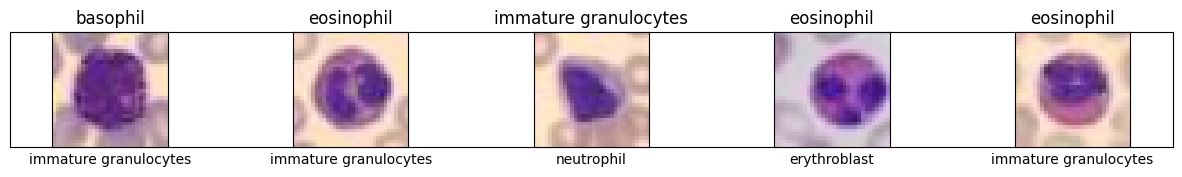

In [ ]:
#  Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(15, 1.5))
plt.xticks([])
plt.yticks([])

for i in range(1, 2, 1):
    for j in range(1, 6, 1):
        fig.add_subplot(1, 5, j)
        plt.imshow(X_test[difs_list[j]], interpolation = "none")
        plt.xticks([])
        plt.yticks([])
        plt.title(f'{dict_classes[str(subset_y_test[j])]}')
        plt.xlabel(f'{dict_classes[str(subset_y_pred[j])]}')
# plt.set_axis_off()
plt.savefig(f'{path_drive}/ResNet/fig_test_samples_images_5epochs.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_test_samples_images_5epochs.png', format='png', bbox_inches="tight")
plt.show()

In [ ]:
ret2 = [23.501379013061523, 0.15258696675300598]

In [ ]:
cm2=confusion_matrix(y_test.flatten(), np.argmax(ret_model2.predict(X_test), axis = 1).flatten())
plot_conf_matrix(y_test.flatten(), np.argmax(ret_model2.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"_units_1024_epoch_15_batch_size_64_n_test_0_optimizer_Adam")

### Execution 3

- Unit = 1024
- Batch size = 64
- Epoch = 5


In [ ]:
ret3, ret_model3, ret_hist3 = setup_RESNET_model(units=1024, drop_out=0, batch_size=64, epochs=5, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')



kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=64, Epochs=5


KeyboardInterrupt: 

In [ ]:
ret3

[9.739662170410156, 0.1423560380935669]

107/107 [==============================] - 15s 137ms/step


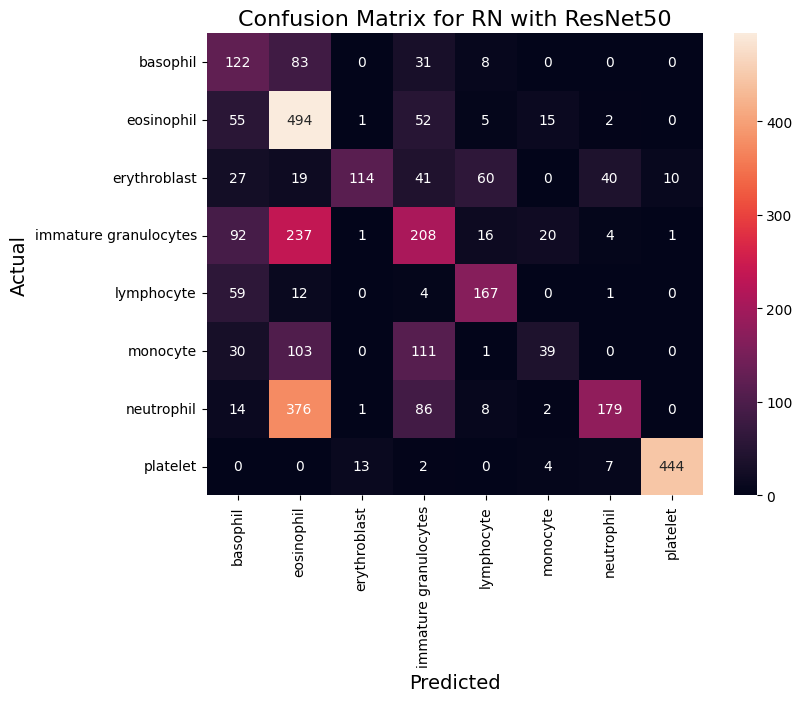

In [ ]:
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model3.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model3.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoTraining_units_1024_epoch_5_batch_size_64_n_test_0_optimizer_Adam")

### Execution 04

- Unit = 1024
- Batch size = 64
- Epoch = 15

kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=64, Epochs=15
Epoch 1/15
187/187 [==============================] - 67s 330ms/step - loss: 1.7571 - categorical_accuracy: 0.3533 - val_loss: 1.4553 - val_categorical_accuracy: 0.4673
Epoch 2/15
187/187 [==============================] - 67s 357ms/step - loss: 1.3114 - categorical_accuracy: 0.5078 - val_loss: 1.4054 - val_categorical_accuracy: 0.4784
Epoch 3/15
187/187 [==============================] - 57s 306ms/step - loss: 1.1835 - categorical_accuracy: 0.5560 - val_loss: 1.1338 - val_categorical_accuracy: 0.5783
Epoch 4/15
187/187 [==============================] - 61s 324ms/step - loss: 1.1458 - categorical_accuracy: 0.5609 - val_loss: 1.1181 - val_categorical_accuracy: 0.5678
Epoch 5/15
187/187 [==============================] - 59s 318ms/step - loss: 1.1017 - categorical_accuracy: 0.5808 - val_loss: 1.0482 - val_categorical_accuracy: 0.

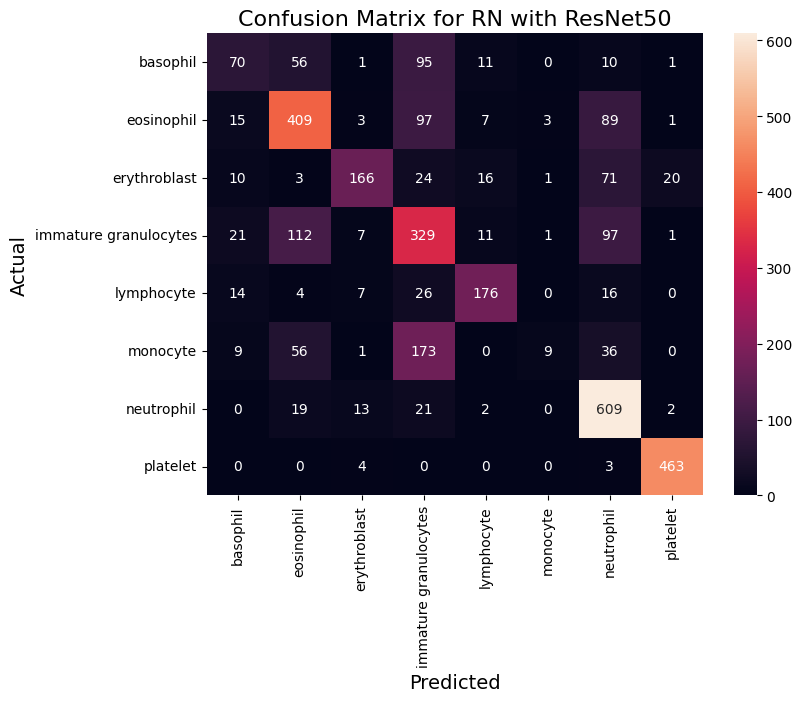

In [ ]:
ret4, ret_model4, ret_hist4 = setup_RESNET_model(units=1024, drop_out=0, batch_size=64, epochs=15, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model4.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model4.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoTraining_units_1024_epoch_15_batch_size_64_n_test_0_optimizer_Adam")

### Execution 05


- Unit = 1024
- Batch size = 64
- Epoch = 30

kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=64, Epochs=30
Epoch 1/30
187/187 [==============================] - 64s 311ms/step - loss: 1.7824 - categorical_accuracy: 0.3562 - val_loss: 1.4019 - val_categorical_accuracy: 0.4842
Epoch 2/30
187/187 [==============================] - 63s 337ms/step - loss: 1.3206 - categorical_accuracy: 0.5082 - val_loss: 1.2344 - val_categorical_accuracy: 0.5047
Epoch 3/30
187/187 [==============================] - 62s 330ms/step - loss: 1.1885 - categorical_accuracy: 0.5514 - val_loss: 1.1025 - val_categorical_accuracy: 0.5619
Epoch 4/30
187/187 [==============================] - 55s 292ms/step - loss: 1.1470 - categorical_accuracy: 0.5657 - val_loss: 1.1079 - val_categorical_accuracy: 0.5970
Epoch 5/30
187/187 [==============================] - 57s 304ms/step - loss: 1.0892 - categorical_accuracy: 0.5857 - val_loss: 1.0526 - val_categorical_accuracy: 0.

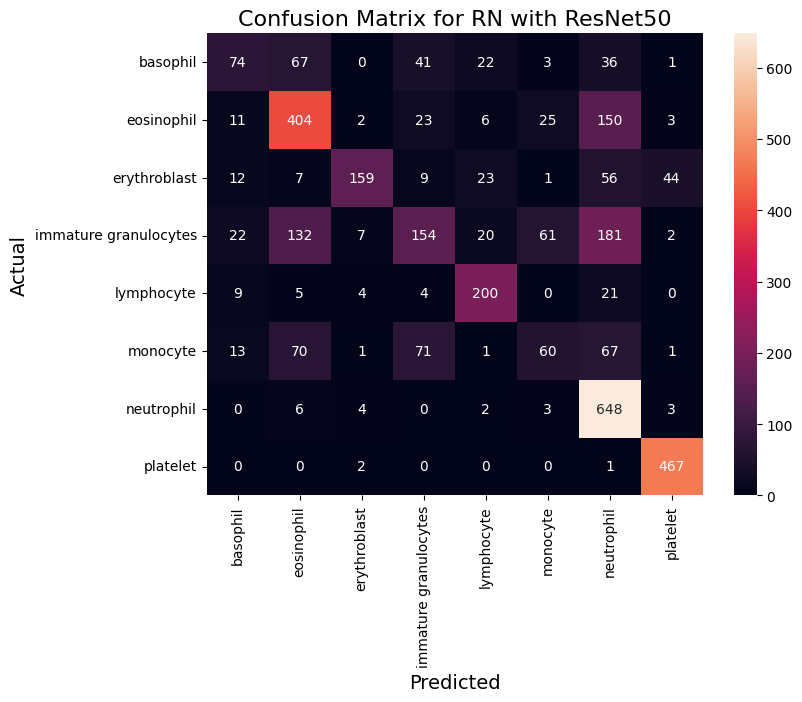

In [ ]:
ret5, ret_model5, ret_hist5 = setup_RESNET_model(units=1024, drop_out=0, batch_size=64, epochs=30, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model5.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model5.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoTraining_units_1024_epoch_30_batch_size_64_n_test_0_optimizer_Adam")

### Plot Accuracy for returns

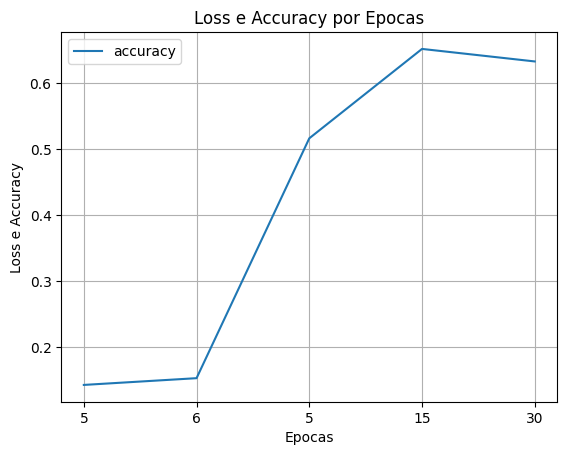

[9.739662170410156, 23.501379013061523, 1.247813105583191, 0.9279177784919739, 0.9595268964767456]
[0.1423560380935669, 0.15258696675300598, 0.5165156126022339, 0.6521484851837158, 0.633148193359375]


In [ ]:
# ret: treinamento com resnet Dense com 512, Epocas=5
# ret2:
# ret3: treinamento com resnet Dense com 1024, Epocas=5
# ret4: treinamento com resnet Dense com 1024, Epocas=15
# ret5: treinamento com resnet Dense com 1024, Epocas=30
loss_total = []
acc_total = []

x_label=['5', '6', '5', '15', '30']
ret_total = [ret, ret2, ret3, ret4, ret5]
for i in range(0, len(ret_total), 1):
  loss_total.append(ret_total[i][0])
  acc_total.append(ret_total[i][1])

# plt.plot(range(0,5,1), loss_total, label='loss')
fig, ax = plt.subplots()
plt.plot(range(0,5,1), acc_total, label='accuracy')
ax.set_xticks(range(0,5,1))
ax.set_xticklabels(x_label)
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Loss e Accuracy')
plt.title('Loss e Accuracy por Epocas')
plt.legend()
plt.grid()
plt.show()

print(loss_total)
print(acc_total)


### Loss History

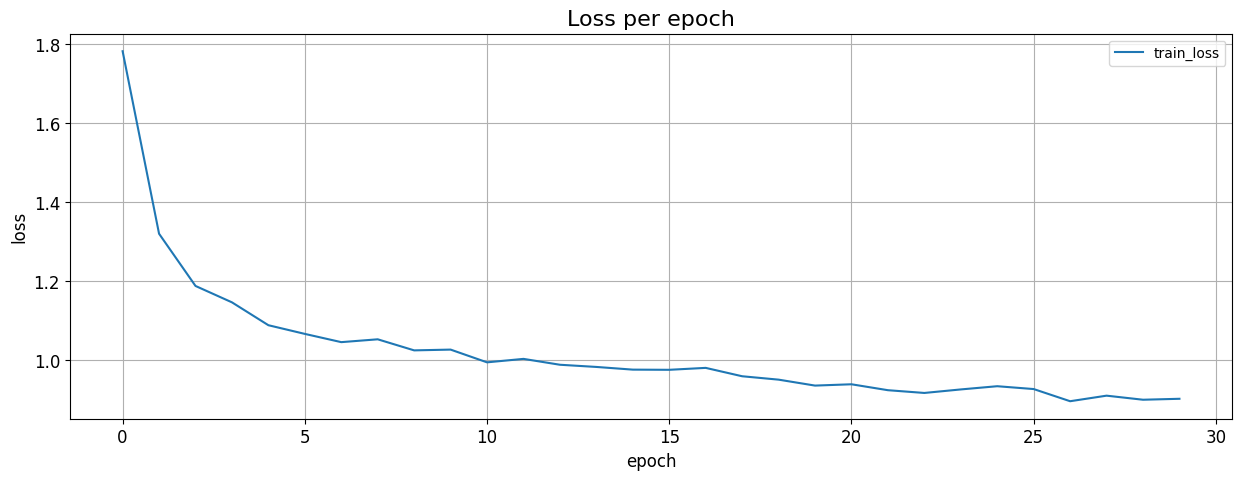

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':ret_hist5.history['loss']})
plot_df.plot(logy=False, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Loss per epoch', fontsize=16)
plt.grid()
plt.savefig(f'{path_drive}/ResNet/fig_loss_per_epoch.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_loss_per_epoch.png', format='png', bbox_inches="tight")
plt.show()

In [ ]:
ret_hist5.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

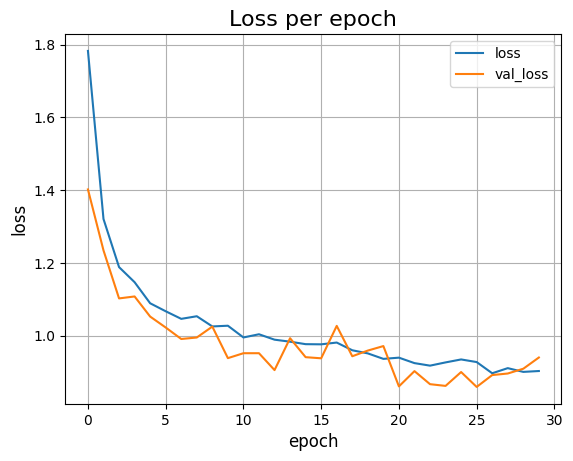

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_acc':ret_hist5.history['loss']})
plot_df2 = pd.DataFrame.from_dict({'train_acc':ret_hist5.history['val_loss']})
# plot_df.plot(logy=False, figsize=(15,5), fontsize=12)
# plot_df2.plot(logy=False, figsize=(15,5), fontsize=12)

plt.plot(plot_df, label='loss')
plt.plot(plot_df2,  label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Loss per epoch', fontsize=16)
plt.grid()
plt.savefig(f'{path_drive}/ResNet/fig_loss_per_epoch.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_loss_per_epoch.png', format='png', bbox_inches="tight")
plt.show()

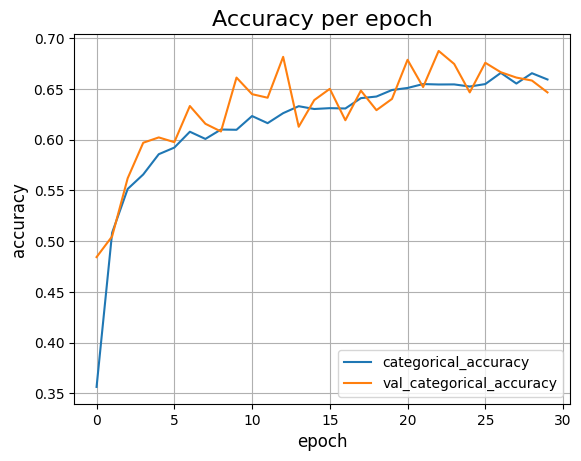

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_acc':ret_hist5.history['categorical_accuracy']})
plot_df2 = pd.DataFrame.from_dict({'train_acc':ret_hist5.history['val_categorical_accuracy']})
# plot_df.plot(logy=False, figsize=(15,5), fontsize=12)
# plot_df2.plot(logy=False, figsize=(15,5), fontsize=12)

plt.plot(plot_df, label='categorical_accuracy')
plt.plot(plot_df2,  label='val_categorical_accuracy')
plt.legend(loc='best')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.title('Accuracy per epoch', fontsize=16)
plt.grid()
plt.savefig(f'{path_drive}/ResNet/fig_acc_per_epoch.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_acc_per_epoch.png', format='png', bbox_inches="tight")
plt.show()


### Execution 06

 **Replica paper**

- Unit = 1024
- Batch size = 64
- Epoch = 100

kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=128, Epochs=100
Epoch 1/100
94/94 [==============================] - 8s 46ms/step - loss: 2.0278 - categorical_accuracy: 0.3048 - val_loss: 1.5288 - val_categorical_accuracy: 0.3902
Epoch 2/100
94/94 [==============================] - 2s 22ms/step - loss: 1.4725 - categorical_accuracy: 0.4607 - val_loss: 1.3233 - val_categorical_accuracy: 0.5105
Epoch 3/100
94/94 [==============================] - 2s 20ms/step - loss: 1.2961 - categorical_accuracy: 0.5146 - val_loss: 1.1797 - val_categorical_accuracy: 0.5619
Epoch 4/100
94/94 [==============================] - 2s 21ms/step - loss: 1.1751 - categorical_accuracy: 0.5710 - val_loss: 1.2143 - val_categorical_accuracy: 0.5018
Epoch 5/100
94/94 [==============================] - 2s 20ms/step - loss: 1.1574 - categorical_accuracy: 0.5668 - val_loss: 1.0534 - val_categorical_accuracy: 0.6069
Epoch 6/

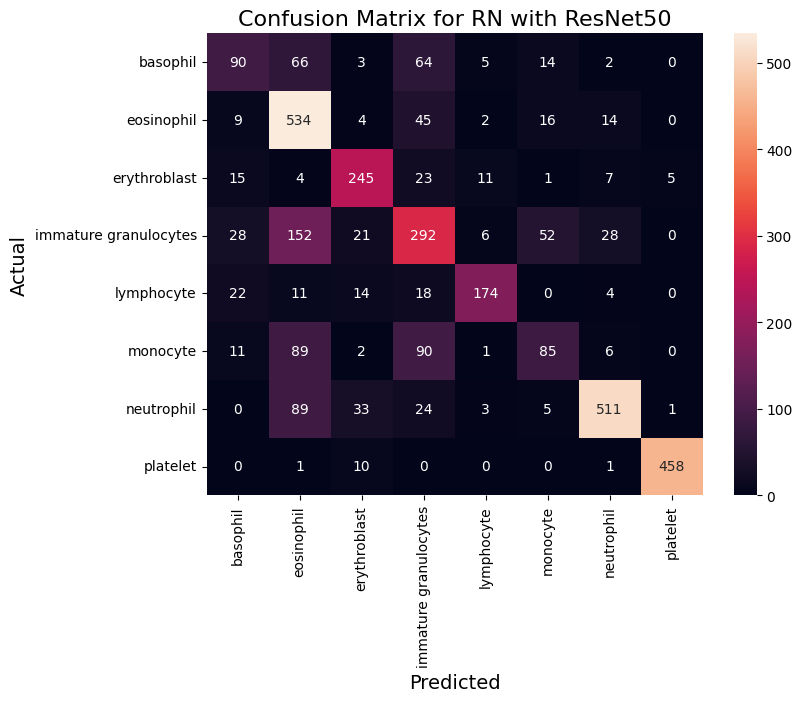

In [ ]:
ret6, ret_model6, ret_hist6 = setup_RESNET_model(units=1024, drop_out=0, batch_size=128, epochs=100, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model6.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model6.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoTraining_units_1024_epoch_100_batch_size_128_n_test_0_optimizer_Adam")

### Treinamento da Resnet50

- Unit = 1024
- Batch size = 64
- Epoch = 5

In [ ]:
from tensorflow.keras import datasets, layers, models, losses, Model

def setup_RESNET2_model(units=1024, drop_out=0, batch_size=64, epochs=5, n=1,
                    algorithm='sparse_categorical_crossentropy',
                    qtd_kernel=15, height_k=3, width_k=3, activation='relu'):
  model = tf.keras.models.Sequential()

  print(f'kernel=({height_k},{width_k}), {qtd_kernel} filters kernel \n algorithm {algorithm}, option algorithm (1) loss and (2) optimizer = {n}')
  print(f'Dropout={drop_out}, Batch_size={batch_size}, Epochs={epochs}')


  model.add(ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3)))

  model.add(layers.Flatten())
  # model.add(layers.Dense(units, activation=activation))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(8, activation = 'softmax'))

  model.layers[0].trainable = False

  model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam()
          )

  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size)

  # present the structure of model initialized
  model.summary()

  # Evaluate the model on the test data
  print("Evaluate on test data")
  results = model.evaluate(X_test, y_test)

  print("test loss, test acc:", results)

  # Save the informations in local drive folder
  model_json = model.to_json()
  dir_path = f'{path_drive}/ResNet'
  name_file= f'/model_n{n}_algorithm_{algorithm}_{units}_units_{drop_out}_drop_out_{batch_size}_batch_size_{epochs}_epocs'
  json_file = open(f'{dir_path}/JSON/{name_file}.json', "w")
  json_file.write(model_json)
  json_file.close()
  model.save_weights(f'{name_file}.h5')

  print("Model saved to disk")

  return results, model, history

kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=128, Epochs=100
Epoch 1/100
94/94 [==============================] - 8s 30ms/step - loss: 1.9709 - categorical_accuracy: 0.2386 - val_loss: 1.7849 - val_categorical_accuracy: 0.2909
Epoch 2/100
94/94 [==============================] - 2s 20ms/step - loss: 1.7040 - categorical_accuracy: 0.3709 - val_loss: 1.6346 - val_categorical_accuracy: 0.4077
Epoch 3/100
94/94 [==============================] - 2s 19ms/step - loss: 1.6001 - categorical_accuracy: 0.4117 - val_loss: 1.5377 - val_categorical_accuracy: 0.4013
Epoch 4/100
94/94 [==============================] - 2s 19ms/step - loss: 1.5194 - categorical_accuracy: 0.4693 - val_loss: 1.4611 - val_categorical_accuracy: 0.5093
Epoch 5/100
94/94 [==============================] - 4s 39ms/step - loss: 1.4615 - categorical_accuracy: 0.4821 - val_loss: 1.4087 - val_categorical_accuracy: 0.5275
Epoch 6/

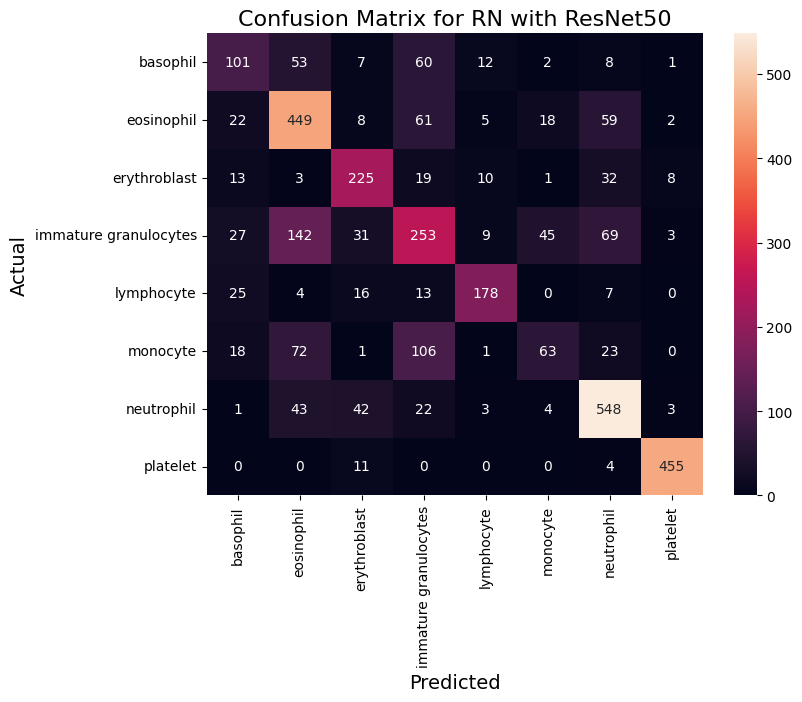

In [ ]:
ret62, ret_model62, ret_hist62 = setup_RESNET2_model(units=1024, drop_out=0, batch_size=128, epochs=100, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model62.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model62.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoDense_replica2_units_1024_epoch_100_batch_size_128_n_test_0_optimizer_Adam")

### Treinamento Resnet - terceira config

In [ ]:
from tensorflow.keras import datasets, layers, models, losses, Model

def setup_RESNET3_model(units=1024, drop_out=0, batch_size=64, epochs=5, n=1,
                    algorithm='sparse_categorical_crossentropy',
                    qtd_kernel=15, height_k=3, width_k=3, activation='relu'):
  model = tf.keras.models.Sequential()

  print(f'kernel=({height_k},{width_k}), {qtd_kernel} filters kernel \n algorithm {algorithm}, option algorithm (1) loss and (2) optimizer = {n}')
  print(f'Dropout={drop_out}, Batch_size={batch_size}, Epochs={epochs}')


  model.add(ResNet50(weights = 'imagenet', include_top = False, classes=8, input_shape = (32,32,3)))

  model.add(layers.Flatten())
  model.add(layers.Dense(units, activation=activation))
  model.add(layers.Dropout(drop_out))
  model.add(layers.Dense(8, activation = 'softmax'))

  model.layers[0].trainable = False

  model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam()
          )

  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size)

  # present the structure of model initialized
  model.summary()

  # Evaluate the model on the test data
  print("Evaluate on test data")
  results = model.evaluate(X_test, y_test)

  print("test loss, test acc:", results)

  # Save the informations in local drive folder
  model_json = model.to_json()
  dir_path = f'{path_drive}/ResNet'
  name_file= f'/model_n{n}_algorithm_{algorithm}_{units}_units_{drop_out}_drop_out_{batch_size}_batch_size_{epochs}_epocs'
  json_file = open(f'{dir_path}/JSON/{name_file}.json', "w")
  json_file.write(model_json)
  json_file.close()
  model.save_weights(f'{name_file}.h5')

  print("Model saved to disk")

  return results, model, history

kernel=(3,3), 5 filters kernel 
 algorithm sparse_categorical_crossentropy, option algorithm (1) loss and (2) optimizer = 1
Dropout=0, Batch_size=128, Epochs=100
Epoch 1/100
94/94 [==============================] - 7s 37ms/step - loss: 1.9660 - categorical_accuracy: 0.3081 - val_loss: 1.5066 - val_categorical_accuracy: 0.5280
Epoch 2/100
94/94 [==============================] - 2s 21ms/step - loss: 1.4504 - categorical_accuracy: 0.4637 - val_loss: 1.3170 - val_categorical_accuracy: 0.4761
Epoch 3/100
94/94 [==============================] - 2s 20ms/step - loss: 1.2891 - categorical_accuracy: 0.5242 - val_loss: 1.2015 - val_categorical_accuracy: 0.5713
Epoch 4/100
94/94 [==============================] - 2s 20ms/step - loss: 1.1879 - categorical_accuracy: 0.5645 - val_loss: 1.0996 - val_categorical_accuracy: 0.6022
Epoch 5/100
94/94 [==============================] - 2s 19ms/step - loss: 1.1554 - categorical_accuracy: 0.5662 - val_loss: 1.0881 - val_categorical_accuracy: 0.5748
Epoch 6/

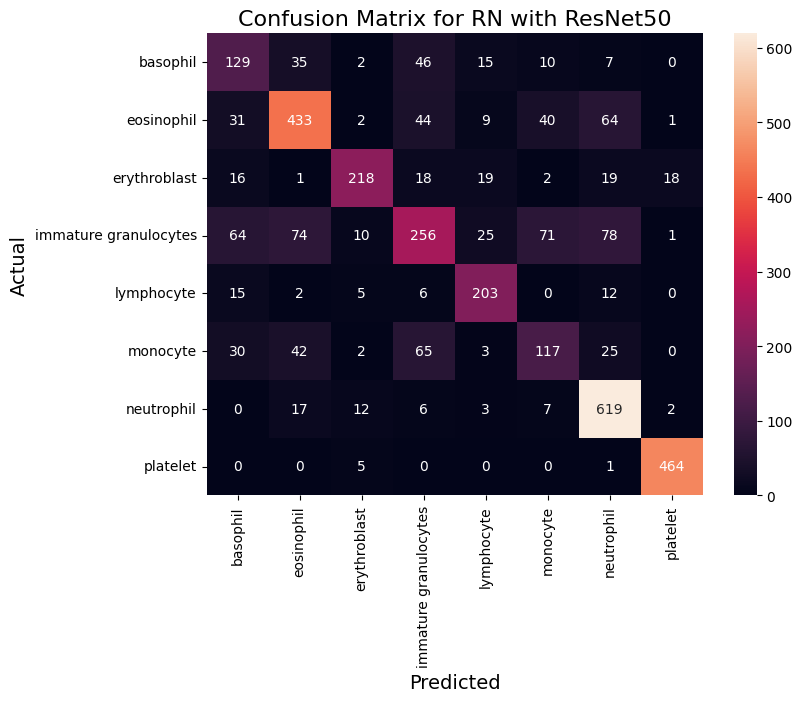

In [ ]:
ret63, ret_model63, ret_hist63 = setup_RESNET3_model(units=1024, drop_out=0, batch_size=128, epochs=100, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model63.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model63.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoDense_replica3_units_1024_epoch_100_batch_size_128_n_test_0_optimizer_Adam")

### Treinamento Resnet - quarta config

In [ ]:
from tensorflow.keras import datasets, layers, models, losses, Model

def setup_RESNET4_model(units=1024, drop_out=0, batch_size=64, epochs=5, n=1,
                    algorithm='sparse_categorical_crossentropy',
                    qtd_kernel=15, height_k=3, width_k=3, activation='relu'):
  # model = tf.keras.models.Sequential()

  # print(f'kernel=({height_k},{width_k}), {qtd_kernel} filters kernel \n algorithm {algorithm}, option algorithm (1) loss and (2) optimizer = {n}')
  print(f'Dropout={drop_out}, Batch_size={batch_size}, Epochs={epochs}')


  base_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
  for layer in base_model.layers:
    layer.trainable = False

  x = layers.Flatten()(base_model.output)
  x = layers.Dense(units, activation='relu')(x)
  predictions = layers.Dense(8, activation = 'softmax')(x)

  model = Model(inputs = base_model.input, outputs = predictions)

  model.compile(
          loss  = tf.keras.losses.CategoricalCrossentropy(),
          metrics = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam()
          )

  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size)

  # present the structure of model initialized
  # model.summary()

  # Evaluate the model on the test data
  print("Evaluate on test data")
  results = model.evaluate(X_test, y_test)

  print("test loss, test acc:", results)

  # Save the informations in local drive folder
  model_json = model.to_json()
  dir_path = f'{path_drive}/ResNet'
  name_file= f'/model_n{n}_algorithm_{algorithm}_{units}_units_{drop_out}_drop_out_{batch_size}_batch_size_{epochs}_epocs'
  json_file = open(f'{dir_path}/JSON/{name_file}.json', "w")
  json_file.write(model_json)
  json_file.close()
  model.save_weights(f'{name_file}.h5')

  print("Model saved to disk")

  return results, model, history

Dropout=0, Batch_size=128, Epochs=5
Epoch 1/5
94/94 [==============================] - 7s 34ms/step - loss: 2.2911 - categorical_accuracy: 0.6155 - val_loss: 0.6839 - val_categorical_accuracy: 0.7570
Epoch 2/5
94/94 [==============================] - 2s 21ms/step - loss: 0.6535 - categorical_accuracy: 0.7634 - val_loss: 0.7003 - val_categorical_accuracy: 0.7617
Epoch 3/5
94/94 [==============================] - 2s 22ms/step - loss: 0.5754 - categorical_accuracy: 0.7930 - val_loss: 0.5757 - val_categorical_accuracy: 0.7868
Epoch 4/5
94/94 [==============================] - 2s 23ms/step - loss: 0.5157 - categorical_accuracy: 0.8150 - val_loss: 0.6558 - val_categorical_accuracy: 0.7728
Epoch 5/5
94/94 [==============================] - 2s 22ms/step - loss: 0.4860 - categorical_accuracy: 0.8259 - val_loss: 0.6253 - val_categorical_accuracy: 0.7769
Evaluate on test data
107/107 [==============================] - 1s 11ms/step - loss: 0.6311 - categorical_accuracy: 0.7743
test loss, test acc:

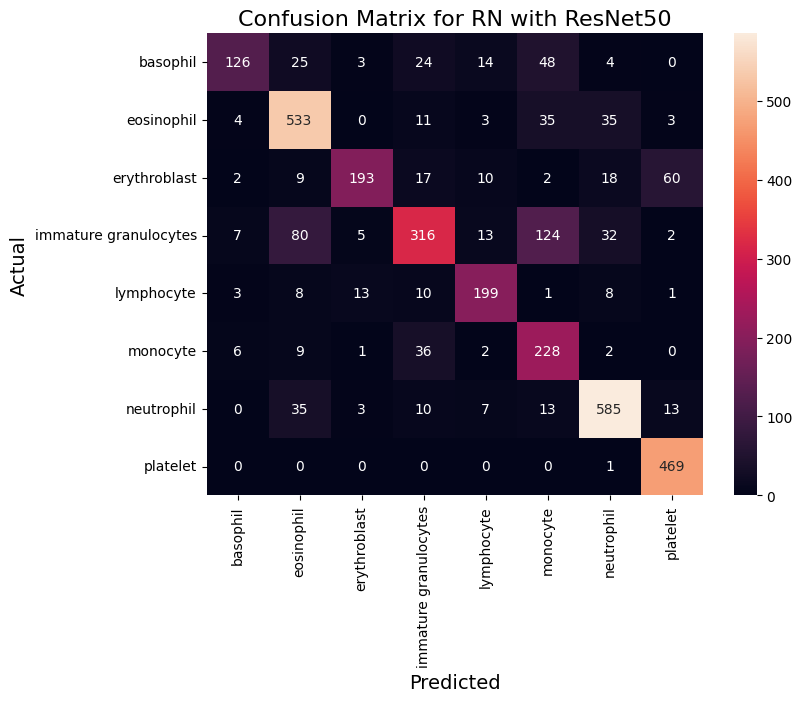

In [ ]:
ret65, ret_model65, ret_hist65 = setup_RESNET4_model(units=1024, drop_out=0, batch_size=128, epochs=5, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model65.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model65.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"NoDense_replica5_units_1024_epoch_5_batch_size_128_n_test_0_optimizer_Adam")

Dropout=0, Batch_size=128, Epochs=100
Epoch 1/100
94/94 [==============================] - 86s 865ms/step - loss: 1.9862 - categorical_accuracy: 0.3200 - val_loss: 1.5005 - val_categorical_accuracy: 0.4988
Epoch 2/100
94/94 [==============================] - 57s 610ms/step - loss: 1.4657 - categorical_accuracy: 0.4522 - val_loss: 1.2961 - val_categorical_accuracy: 0.5251
Epoch 3/100
94/94 [==============================] - 61s 651ms/step - loss: 1.2848 - categorical_accuracy: 0.5352 - val_loss: 1.1687 - val_categorical_accuracy: 0.5917
Epoch 4/100
94/94 [==============================] - 58s 618ms/step - loss: 1.2213 - categorical_accuracy: 0.5480 - val_loss: 1.2098 - val_categorical_accuracy: 0.5607
Epoch 5/100
94/94 [==============================] - 59s 632ms/step - loss: 1.1590 - categorical_accuracy: 0.5671 - val_loss: 1.1290 - val_categorical_accuracy: 0.5923
Epoch 6/100
94/94 [==============================] - 60s 640ms/step - loss: 1.1300 - categorical_accuracy: 0.5761 - val_lo

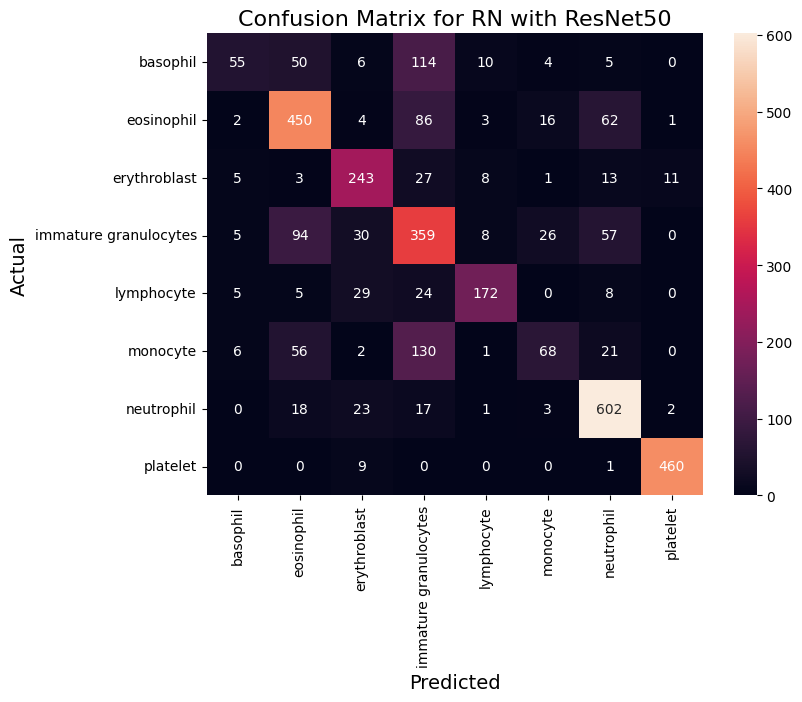

In [ ]:
ret_replica, ret_model_replica, ret_hist_replica = setup_RESNET4_model(units=1024, drop_out=0, batch_size=128, epochs=100, n=1,
                                                        algorithm='sparse_categorical_crossentropy',
                                                        qtd_kernel=5, height_k=3, width_k=3, activation='relu')
cm2=confusion_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model_replica.predict(X_test), axis = 1).flatten())
cm2
plot_conf_matrix(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model_replica.predict(X_test), axis = 1).flatten(),
                  f"RN with ResNet50", show_plot=False, cm=cm2,
                  details=f"Replica_paper_resnet_100_epochs_no_normalized")

In [ ]:
report_class= classification_report(np.argmax(y_test, axis = 1).flatten(), np.argmax(ret_model_replica.predict(X_test), axis = 1).flatten())
print(report_class)

107/107 [==============================] - 17s 160ms/step
              precision    recall  f1-score   support

           0       0.71      0.23      0.34       244
           1       0.67      0.72      0.69       624
           2       0.70      0.78      0.74       311
           3       0.47      0.62      0.54       579
           4       0.85      0.71      0.77       243
           5       0.58      0.24      0.34       284
           6       0.78      0.90      0.84       666
           7       0.97      0.98      0.97       470

    accuracy                           0.70      3421
   macro avg       0.72      0.65      0.65      3421
weighted avg       0.71      0.70      0.69      3421



### Comparando amostras diferentes

In [ ]:
### Block used to evaluate the not wrong predictions individually
subset_y_pred = ret_model_replica.predict(X_test)
subset_y_pred = np.argmax(subset_y_pred, axis = 1).flatten()

difs_list = subset_y_pred - np.argmax(y_test, axis = 1).flatten()
difs_list = np.where(difs_list != 0)[0]
print(difs_list)

subset_x_test = []
subset_y_test = []
for i in range(0, 6, 1):
  subset_x_test.append( X_test[difs_list[i]] )
  subset_y_test.append( np.argmax(y_test, axis = 1).flatten()[difs_list[i]] )

print(subset_y_pred)
print(subset_y_test)

107/107 [==============================] - 18s 162ms/step
[   0    1    3 ... 3412 3413 3414]
[1 1 1 ... 3 1 7]
[3, 0, 3, 1, 1, 2]


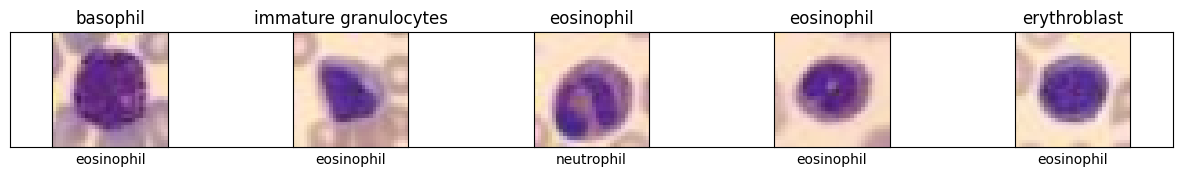

In [ ]:
#  Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(15, 1.5))
plt.xticks([])
plt.yticks([])

for i in range(1, 2, 1):
    for j in range(1, 6, 1):
        fig.add_subplot(1, 5, j)
        plt.imshow(X_test[difs_list[j]], interpolation = "none")
        plt.xticks([])
        plt.yticks([])
        plt.title(f'{dict_classes[str(subset_y_test[j])]}')
        plt.xlabel(f'{dict_classes[str(subset_y_pred[j])]}')
# plt.set_axis_off()
plt.savefig(f'{path_drive}/ResNet/fig_test_samples_images_100_epochs.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_test_samples_images_100_epochs.png', format='png', bbox_inches="tight")
plt.show()

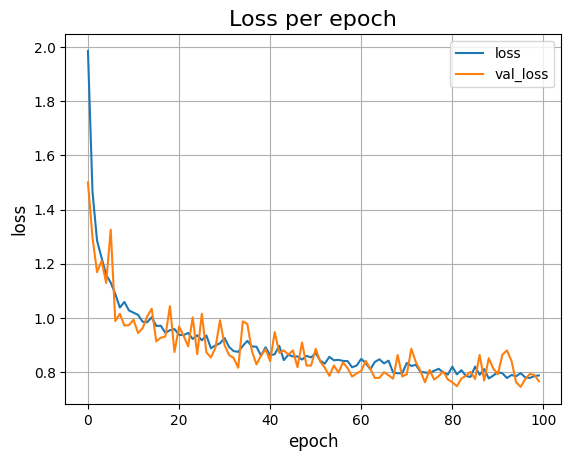

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_acc':ret_hist_replica.history['loss']})
plot_df2 = pd.DataFrame.from_dict({'train_acc':ret_hist_replica.history['val_loss']})
# plot_df.plot(logy=False, figsize=(15,5), fontsize=12)
# plot_df2.plot(logy=False, figsize=(15,5), fontsize=12)

plt.plot(plot_df, label='loss')
plt.plot(plot_df2,  label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Loss per epoch', fontsize=16)
plt.grid()
plt.savefig(f'{path_drive}/ResNet/fig_loss_per_epoch_100_epochs.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_loss_per_epoch_100_epochs.png', format='png', bbox_inches="tight")
plt.show()

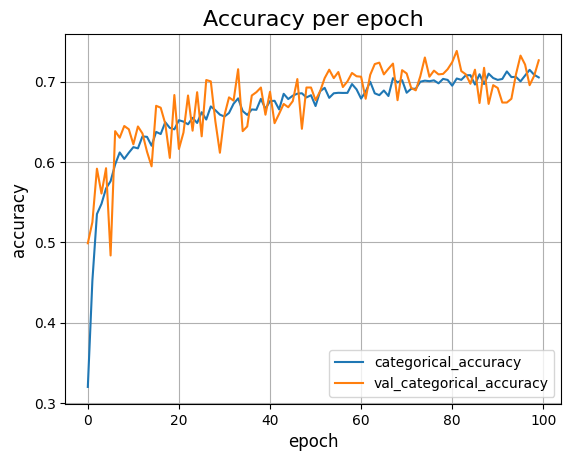

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_acc':ret_hist_replica.history['categorical_accuracy']})
plot_df2 = pd.DataFrame.from_dict({'train_acc':ret_hist_replica.history['val_categorical_accuracy']})
# plot_df.plot(logy=False, figsize=(15,5), fontsize=12)
# plot_df2.plot(logy=False, figsize=(15,5), fontsize=12)

plt.plot(plot_df, label='categorical_accuracy')
plt.plot(plot_df2,  label='val_categorical_accuracy')
plt.legend(loc='best')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.title('Accuracy per epoch', fontsize=16)
plt.grid()
plt.savefig(f'{path_drive}/ResNet/fig_acc_per_epoch_100_epochs.eps', format='eps', bbox_inches="tight")
plt.savefig(f'{path_drive}/ResNet/fig_acc_per_epoch_100_epochs.png', format='png', bbox_inches="tight")
plt.show()
